# Process Cap Quotes

This notebook 
* converts Bloomberg cap quotes into Black flat vols.
* interpolates the vol curve
* interpolates the SOFR swap curve from BB quotes.
* calculates swap, discount, and forward curves

User picks a date, and among the historic dates loaded, it builds the curves for this particular date.

Pair this notebook with `build_data/Build Cap Quotes - Bloomberg`.

In [1]:
import numpy as np
import pandas as pd

import sys
sys.path.insert(0, '../cmds')
from ratecurves import *

from datetime import datetime
import warnings

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

***

In [3]:
FILEIN = 'cap_quotes_2023-04-21'
FREQ = 52

### Select Date for Analysis

In [4]:
DATE = '2023-04-21'

### Export Curves to Excel

In [5]:
SAVEDATA = True
FILEOUT = f'cap_curves_{DATE}_freq_{FREQ}'

# SOFR Quotes

In [6]:
SHEET = 'sofr'
sofrdata = pd.read_excel(f'{FILEIN}.xlsx', sheet_name=SHEET).set_index('date')
sofrdata.columns = sofrdata.loc['maturity'] 
sofrdata.drop(index=['maturity'],inplace=True)
sofrdata.index = pd.to_datetime(sofrdata.index)

Bloomberg reported years-to-maturity are precise.
Round these to nearest $dt$ for better column headers
For more precise work, would need to make use of the precise maturities, but for this purpose will make no difference.

In [7]:
sofrdata.columns = (FREQ*sofrdata.columns.values).round(0)/FREQ
sofrdata.columns.name ='maturity'

Bloomberg reports rates as percentages; convert to numbers.

In [8]:
sofrdata /= 100

Bloomberg allows downloading of ticker codes corresponding to 10.X years, but they are really just the 10-year code.

Called ticker list built to check all partial years, so it gets these redundant 10-year columns.

In [9]:
sofrdata = sofrdata.T.drop_duplicates().T

## Get Curves

Need discount and forward curves.

Need to interpolate swap rates for quarterly frequency beyond $T=3$ (which is where Bloomberg moves from monthly to semiannual tenors.)

Many reasonable methods, try `cubicspline`.

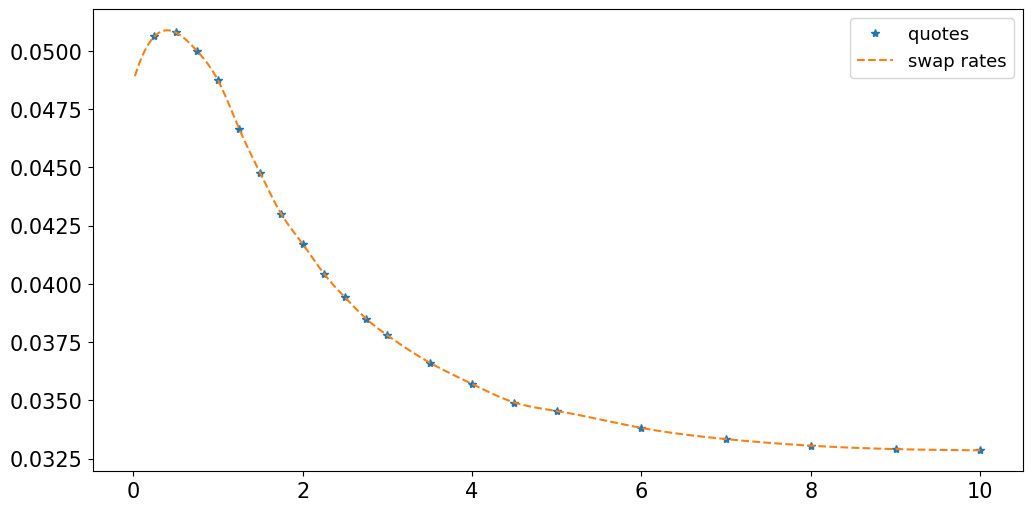

In [10]:
sofrcurves = interp_curves(sofrdata, dt = 1/FREQ, date=DATE, interp_method='cubicspline').rename(columns={'interp':'swap rates'})
plot_interp_curves(sofrcurves)

<Axes: >

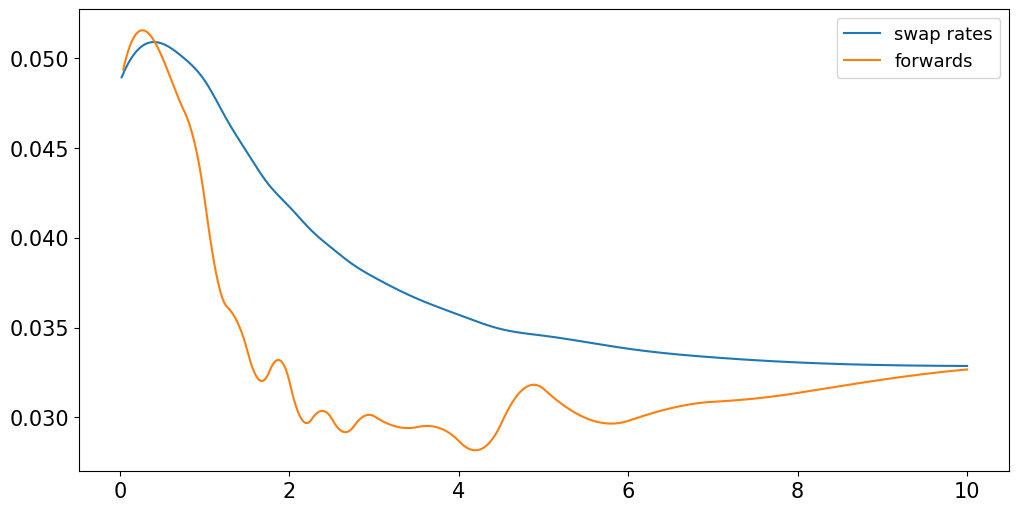

In [11]:
sofrcurves['discounts'] = ratecurve_to_discountcurve(sofrcurves['swap rates'],n_compound=FREQ)
sofrcurves['forwards'] = ratecurve_to_forwardcurve(sofrcurves['swap rates'],n_compound=FREQ)

sofrcurves[['swap rates','forwards']].plot()

# Cap Quotes

In [12]:
SHEET = 'cap'
capdata = pd.read_excel(f'{FILEIN}.xlsx', sheet_name=SHEET).set_index('date')
capdata.columns = capdata.loc['maturity'] 
capdata.drop(index=['maturity'],inplace=True)
capdata.index = pd.to_datetime(capdata.index)

Bloomberg reported years-to-maturity are precise.
Round these to nearest $dt$ for better column headers
For more precise work, would need to make use of the precise maturities, but for this purpose will make no difference.

In [13]:
capdata.columns = (FREQ*capdata.columns.values).round(0)/FREQ
capdata.columns.name ='maturity'

Bloomberg allows downloading of ticker codes corresponding to 10.X years, but they are really just the 10-year code.

Called ticker list built to check all partial years, so it gets these redundant 10-year columns.

In [14]:
capdata = capdata.T.drop_duplicates().T

## Adjusting Normal Vol to Lognormal (Black) Vol

Cap quotes in Bloomberg are downloaded in
* normal vol
* terminal allows view of lognormal (Black) vol, but API seemingly restricts to normal.

The normal vols are reported in basis points.
* divide out by $100^2$

Converting between normal and lognormal vol is given by a simple formula for ATM options, (according to SABR, etc.)

$$\sigma_B = \frac{\sigma_N}{f}$$

where $f$ is the forward rate.

In [15]:
capquotes = capdata.loc[DATE,:].to_frame()
capquotes.columns = ['normal']
capquotes[DATE] = capquotes['normal'] / sofrcurves['forwards'] / 100**2

#### Interpolation
Need to interpolate cap rates for quarterly frequency as Bloomberg reports only at annual tenors.

Try `cubicspline`.

#### Extrapolation
Also need to extrapolate the short end of the curve, $t<1$.
* This can lead to negative values w/ cubic spline and others.
* Here, ad hoc set front to `FRONT_RATIO` the first quote and linearly extrapolate

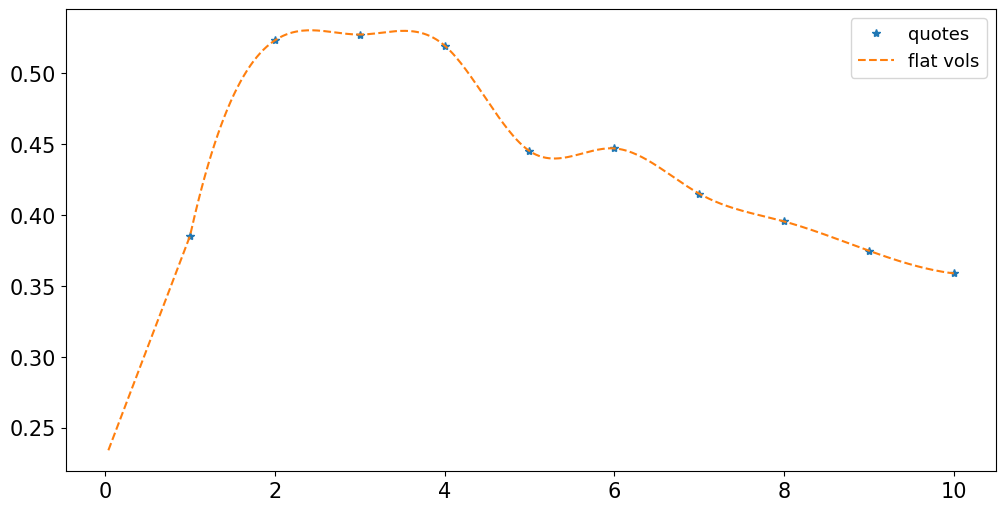

In [16]:
LIN_EXTRAP = True
FRONT_RATIO = .6

capcurves = interp_curves(capquotes[[DATE]].T,dt=1/FREQ, date=DATE,interp_method='cubicspline').rename(columns={'interp':'flat vols'})

if LIN_EXTRAP:
    fix_short = capcurves.loc[:1,'flat vols']
    fix_short.iloc[:-1] = np.nan
    fix_short.iloc[0] = capcurves.loc[1,'flat vols'] * FRONT_RATIO
    capcurves.loc[:1,'flat vols'] = fix_short.interpolate(limit_direction='both', fill_value = 'extrapolate')

# drop extrapolated value at first period as there is no caplet for the first period.
capcurves['flat vols'].iloc[0] = np.nan

plot_interp_curves(capcurves)

### Save Data

In [17]:
outdata = pd.concat([sofrcurves.drop(columns=['quotes']), capcurves.drop(columns=['quotes'])],axis=1)
outdata.index.name = 'tenor'

if SAVEDATA:
    outfile = f'../data/{FILEOUT}.xlsx'
    with pd.ExcelWriter(outfile) as writer:  
        outdata.to_excel(writer, sheet_name= f'rate curves {DATE}', index=True)